#### autoreload modules and utilities

In [1]:
%load_ext autoreload
%autoreload 2

#### import all neceesary libraries/packages

In [2]:
from itertools import combinations

import joblib

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

from scipy.stats import entropy as calculate_entropy

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score as calculate_f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold 

In [3]:
df = pd.DataFrame([[1, 2, 6],[3, 4, 7], [9, 3, 2]])
df

,0,1,2
0,1,2,6
1,3,4,7
2,9,3,2


In [4]:
def sum_weight(x, word_word_pr_distr_prime):
    return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).sum(0)

In [5]:
df.fillna(0)

,0,1,2
0,1,2,6
1,3,4,7
2,9,3,2


In [6]:
df.apply(sum_weight, axis=1, args=(df,))

,0,1,2
0,61,28,32
1,78,43,60
2,36,36,79


#### Utility functions

In [32]:
## utilities
# from utils import clean_text
import re
import string

from sklearn.base import TransformerMixin

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')

def get_lemmatizer():
    return WordNetLemmatizer()

def clean_text(text: str, lemmatizer = None) -> str:
    # removes upper cases
    text = text.lower().strip()
    
    # removes punctuation
    for char in string.punctuation:
        text = text.replace(char, " ")
    
    if lemmatizer is None:
        lemmatizer = lambda x: x
        
    #lematize the words and join back into string text
    text = " ".join([lemmatizer(word) for word in word_tokenize(text) if len(word) >= 2])
        
    return text

def calculate_sparsity(matrix):
    non_zero = np.count_nonzero(matrix)
    total_val = np.product(matrix.shape)
    sparsity = (total_val - non_zero) / total_val
    return sparsity

def data_isvalid(text, analyser, min_character_size, max_character_size):
    return min_character_size <= len(analyser(text)) <= max_character_size 

def get_pipeline(count_vectorizer, classifier, lemmatizer, t2pi_transformer, tfidf_transformer):
    models = [
        ('clean_text', CleanTextTransformer(lemmatizer)),
        ('vectorizer', count_vectorizer)
    ]
    
    if tfidf_transformer is not None:
        models.append(('tfidf_transformer', tfidf_transformer))
        
    models.append(
        ('dense', DenseTransformer(count_vectorizer=count_vectorizer))
    )
    
    if t2pi_transformer is not None:
        models.append(('t2pi_transformer', t2pi_transformer))
    
    models.append(('classifier', classifier))
    return Pipeline(models)

def get_top_words(model, vectorizer, n_top_words):
    top_words = []
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words
    
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_model(classifier, tfidf=False, use_t2pi=False, lemmatizer=None, stop_words="english", vocabulary=None):
    count_vectorizer = CountVectorizer(stop_words=stop_words, binary=False, vocabulary=vocabulary)
    tfidf_transformer = TfidfTransformer() if tfidf else None
    t2pi_transformer = T2PITransformer() if use_t2pi else None

    # normal model
    return get_pipeline(count_vectorizer, classifier, lemmatizer, t2pi_transformer, tfidf_transformer)

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( clean_text(doc) ):
#             for tok in word_tokenize( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                    
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            
class CleanTextTransformer(TransformerMixin):
    def __init__(self, lemmatizer):
        self._lemmatizer = lemmatizer
        
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.vectorize(lambda x: clean_text(x, self._lemmatizer))(X)
    
    def __str__(self):
        return "CleanTextTransformer()"
    
    def __repr__(self):
        return self.__str__()
    
class DenseTransformer(TransformerMixin):
    def __init__(self, count_vectorizer):
        self.count_vectorizer = count_vectorizer
        
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return pd.DataFrame(data=X.todense(), columns=self.count_vectorizer.get_feature_names())
    
    def __str__(self):
        return "DenseTransformer()"
    
    def __repr__(self):
        return self.__str__()
    
class T2PITransformer(TransformerMixin):
    @staticmethod
    def _max_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).max(0)
    
    @staticmethod
    def _sum_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).sum(0)
    
    @staticmethod
    def _weighted_mean_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        xt = word_word_pr_distr_prime.apply(lambda y: x*y, axis=0)
        return (xt * (xt / xt.sum(0))).sum(0)
        
    def fit(self, X, y=None, **fit_params):
        print("creating term-term co-occurence pr matrix")
        self.word_word_pr_distr = pd.DataFrame(data=0.0, columns=X.columns, index=X.columns)
        
        for term in tqdm(X.columns):
            self.word_word_pr_distr[term] = X[X[term] > 0].sum(0) / X[term].sum()
#             self.word_word_pr_distr[term] = X[X[term] > 0].sum(0) / X.sum(0)
        
        self.word_word_pr_distr.fillna(0, inplace=True)
        return self

    def transform(self, X, y=None, **fit_params):
        print("transforming ...")
        
        # new_sparsity after transform
        sparsity_before = calculate_sparsity(X)
        
        # populate
        with tqdm(total=X.shape[0]) as pbar:
            X = X.apply(self._sum_weight, axis=1, args=(pbar, self.word_word_pr_distr))
        
        # new_sparsity after transform
        sparsity_after = calculate_sparsity(X)
        
        print("sparsity(X):")
        print(f"=> before {sparsity_before:.4f}")
        print(f"=>  after {sparsity_after:.4f}")
        print()
        
        return X
    
    def __str__(self):
        return "T2PITransformer()"
    
    def __repr__(self):
        return self.__str__()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## CONSTANTS

In [33]:
N_TOP_WORDS = 10

# Load Data

In [34]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [35]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
categories = all_docs.target_names

In [36]:
print(all_docs.data[0])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


### Create Dataframe

In [37]:
data = pd.DataFrame(
    data={
        "text":all_docs.data, 
        "label":all_docs.target
    }
)

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
1,"\nI don't like this comment about ""Typical"" th...",3
2,\n<apparently you're not a woman - my husband ...,1
3,"While not exactly a service incident, I had a ...",1
4,\n\nI think I can. Largely as a result of effo...,2


### Label Frequency

1    594
2    593
3    564
0    480
Name: label, dtype: int64



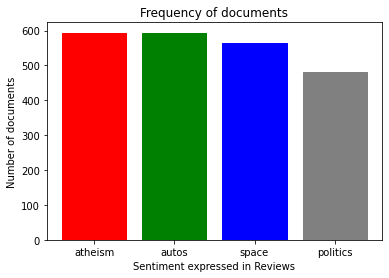

In [38]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

The Dataset labels needs to be balanced

# Select Valid Data

In [39]:
max_size_per_class = 100

# remove long text
indices = data["text"].apply(data_isvalid, args=(lambda x: clean_text(x, get_lemmatizer().lemmatize), 256, 512))
data = data[indices]

# make classes balanced
class_indices = []

for index in range(4):
    class_indices.append(np.where((data["label"] == index))[0])
    
size_per_class = min(max_size_per_class, min(map(len, class_indices)))
indices = np.concatenate([class_ids[:size_per_class] for class_ids in class_indices])

data = data.iloc[indices]

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
30,\n[rest deleted...]\n\nYou were a liberal arts...,0
36,"\nWorse? Maybe not, but it is definately a vi...",0
63,\nCould you expand on your definition of knowi...,0
65,\nLooking at historical evidence such 'perfect...,0


In [40]:
print(data.iloc[0]["text"])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


3    97
2    97
1    97
0    97
Name: label, dtype: int64



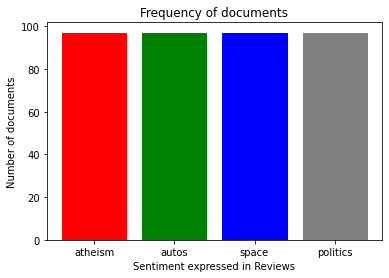

In [41]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

### initialize input and output

In [42]:
X = data["text"]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Create Word2Vec Model

In [43]:
import gensim

docgen = TokenGenerator( X, custom_stop_words )

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=2, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [44]:
vocabulary = dict(zip(w2v_model.wv.vocab.keys(), np.arange(len(w2v_model.wv.vocab))))
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 2088 terms


In [45]:
w2v_model.save("w2v-model.bin")

In [46]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### initialize recursive word infer model

In [47]:
def get_classifier():
    return LatentDirichletAllocation(n_components=4, random_state=0)

In [48]:
# initialize model
t2pi_model = get_model(use_t2pi=True, stop_words=custom_stop_words, vocabulary=vocabulary, classifier=get_classifier())

# fit model
t2pi_model.fit(X_train, y_train)

creating term-term co-occurence pr matrix



transforming ...



sparsity(X):
=> before 0.9900
=>  after 0.4450



Pipeline(steps=[('clean_text', CleanTextTransformer()),
                ('vectorizer',
                 CountVectorizer(stop_words=['a', 'about', 'above', 'according',
                                             'across', 'actually', 'adj',
                                             'after', 'afterwards', 'again',
                                             'all', 'almost', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'an', 'and', 'another', 'any',
                                             'anyhow', 'anyone', 'anything',
                                             'anywhere', 'are', 'aren', ...]...
                                             '18': 1967, '1915': 2060,
                                             '1920': 1398, '1941': 1338,
                                             '1948': 1976, '1967': 1937,
   

In [ ]:
t2pi_model.score(X_train, y_train)

transforming ...


In [ ]:
k = t2pi_model["classifier"].components_.shape[0]
perplexity = t2pi_model["classifier"].bound_
coherence = calculate_coherence(w2v_model, get_top_words(t2pi_model["classifier"], t2pi_model["vectorizer"], N_TOP_WORDS))

print("P=%02d: Perplexity=%.4f" % (k, perplexity))
print("K=%02d: Coherence=%.4f" % (k, coherence))

In [ ]:
print("\nTopics in LDA model:")
print_top_words(t2pi_model["classifier"], t2pi_model["vectorizer"], N_TOP_WORDS)

### Initialize models

In [ ]:
# normal model
count_model = get_model(stop_words=None, vocabulary=vocabulary, classifier=get_classifier())
count_sw_model = get_model(stop_words=custom_stop_words, vocabulary=vocabulary, classifier=get_classifier())

tfidf_model = get_model(tfidf=True, stop_words=None, vocabulary=vocabulary, classifier=get_classifier())
tfidf_sw_model = get_model(tfidf=True, stop_words=custom_stop_words, vocabulary=vocabulary, classifier=get_classifier())

# model
t2pi_count_model = get_model(use_t2pi=True, stop_words=None, vocabulary=vocabulary, classifier=get_classifier())
t2pi_count_sw_model = get_model(use_t2pi=True, stop_words=custom_stop_words, vocabulary=vocabulary, classifier=get_classifier())

t2pi_tfidf_model = get_model(tfidf=True, use_t2pi=True, stop_words=None, vocabulary=vocabulary, classifier=get_classifier())
t2pi_tfidf_sw_model = get_model(tfidf=True, use_t2pi=True, stop_words=custom_stop_words, vocabulary=vocabulary, classifier=get_classifier())

models = {
    "count_model": count_model, 
    "count_sw_model": count_model, 
    "tfidf_model": tfidf_model,
    "tfidf_sw_model": tfidf_sw_model, 
    "t2pi_count_model": t2pi_count_model,
    "t2pi_count_sw_model": t2pi_count_sw_model, 
    "t2pi_tfidf_model": t2pi_tfidf_model, 
    "t2pi_tfidf_sw_model": t2pi_tfidf_sw_model
}

### Running Cross validation on all Models

In [ ]:
split_size = 3
skf = StratifiedKFold(n_splits=split_size, shuffle=True, random_state=100) 

index = 0
perplexities, coherences = [], []

for train_index, test_index in skf.split(X, y):
    index += 1
    
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    perplexities.append([])
    coherences.append([])
    
    for model_name, model in models.items():
        print(f'-> {index}. {model_name} \n{"="*100}\n')
        model.fit(x_train_fold, y_train_fold)
        
        k = model["classifier"].components_.shape[0]
        perplexity = model["classifier"].bound_
        coherence = calculate_coherence(
            w2v_model, 
            get_top_words(
                model["classifier"], 
                model["vectorizer"], 
                N_TOP_WORDS
            )
        )
        
        perplexities[-1].append(perplexity)
        coherences[-1].append(coherence)

In [ ]:
model_names = list(models.keys())

perplexity = pd.DataFrame(data=np.array(perplexities), columns=model_names)
coherence = pd.DataFrame(data=np.array(coherences), columns=model_names)

perplexity.loc["mean"] = perplexity.mean(0)
coherence.loc["mean"] = coherence.mean(0)

In [ ]:
perplexity.head(split_size+1)

In [ ]:
coherence.head(split_size+1)